# <center>**A股预测**</center>
<hr></hr>  

### <center>**实战实验报告**</center>
#### **<center>控制科学与工程学院&emsp;3200100259&emsp;沈骏一</center>**

# 1.实验介绍

## 1.1 实验背景
时间序列分析在金融、证券领域的应用非常广泛，尤其是对股票价格的预测。我们对数据进行预处理，接着使用数据分析方法，建立基础特征，进一步构建线性回归模型，且基于新数据验证模型效果。

## 1.2 实验要求
输入某股票前 14 个交易日的收盘价，预测下一个交易日的收盘价。
实验指标为平均绝对百分比误差（ `MAPE` ）和平均绝对误差（ `MAE` ）。

## 1.3 实验环境 
可以使用基于 `Python` 的 `Pandas` 、 `Numpy` 、`Scikit-learn` 等库进行相关特征处理，使用 `Keras`、`TensorFlow`、`PyTorch` 等框架建立深度学习模型，使用过程中请注意 `Python` 包（库）的版本。



## 1.4 注意事项
- 使用平台的注意事项

该平台的 `Notebook` 在 `CPU` 上运行，故尽量不要尝试在 `Notebook` 上做希望让 `GPU` 做的工作。

- 训练模型的注意事项

如果想要线下训练模型，请保证线下的环境与该平台一致，否则可能无法在该平台运行，可以在该平台的 `terminal` 输入```pip list```查看对应包版本。

- 该作业的注意事项

该作业目的在于加深对空间和时序模型的理解和运用，理论上作品的预测相关指标不应低于基本模型。



## 1.5 参考资料
- 相关框架的文档

scikit-learn: https://scikit-learn.org/stable/

tensorflow: https://tensorflow.google.cn/tutorials?hl=zh_cn

PyTorch: https://pytorch.org/tutorials/

- 框架的学习教程

《动手学深度学习》(PyTorch版): https://tangshusen.me/Dive-into-DL-PyTorch/

《深度学习框架PyTorch：入门与实战》: https://github.com/chenyuntc/pytorch-book
<hr>

# 2.实验内容

## 2.1 数据集

数据集由网上的相关平台获取，训练集给出了五十几支股票的情况。数据以 `npy` 格式给出，名称为`train_data.npy` 。


In [34]:
# 首先 import 一些主要的包
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import os

# 画图使用
%matplotlib inline

In [35]:
# 简单读出一个股票
# 获取文件名
file_name = 'train_data.npy'
# 读取数组
data = np.load(file_name)
# 简单展示信息
data

array([15.35, 15.13, 15.01, ...,  2.93,  2.79,  2.84])

接下来可以对其进行绘制，这样可以具体感受到股价的变化。

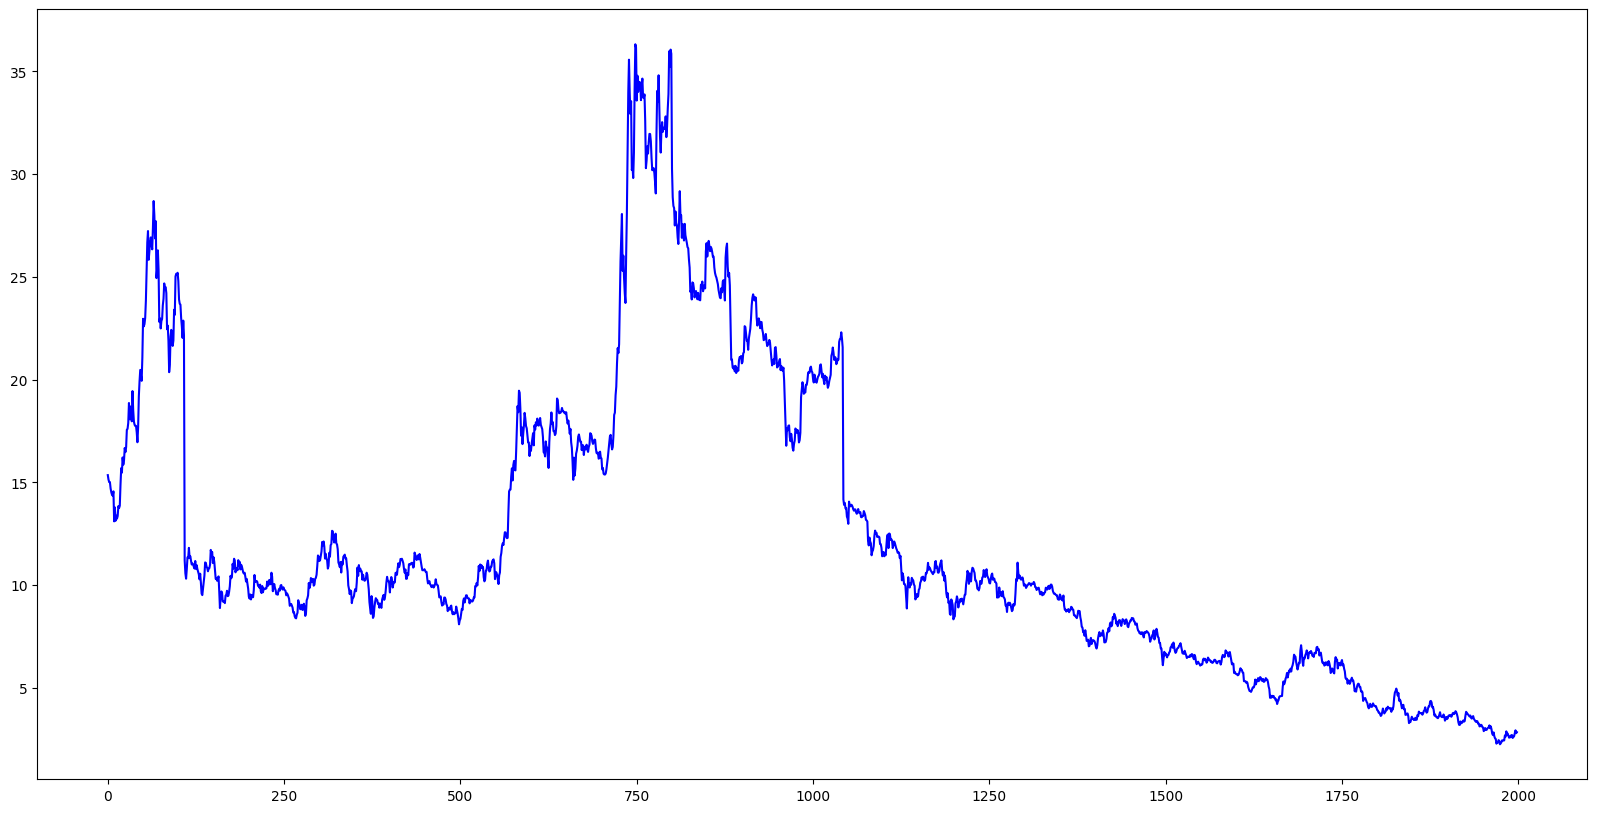

In [36]:
# 新建一个图像
plt.figure(figsize=(20,10))

# 绘画该股票不同的时间段的图像
plt.plot(data,c='blue')

# 展示图像
plt.show()

注意到波动还是比较大的，且数值较大处和较小处相比差距存在，为了深度模型更好的工作，我们使用 `MinMaxScaler` 进行归一化。

这里我们选用 `sklearn` 的 `Scaler` 进行处理。

但注意，如果 `scaler` 运算后的结果小于或等于 $0$ 可能带来严重后果，因为指标之一是 `MAPE` 。

In [37]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(np.array([0, 300]).reshape(-1, 1))

## 2.2 数据处理


首先需要生成题目所需的训练集合。

In [38]:
# 生成题目所需的训练集合
def generate_data(data):
    
    # 记录 data 的长度
    n = data.shape[0]
    
    # 目标是生成可直接用于训练和测试的 x 和 y
    x = []
    y = []
        
    # 建立 (14 -> 1) 的 x 和 y
    for i in range(15, n):
        x.append(data[i-15:i-1])
        y.append(data[i-1])
            
    # 转换为 numpy 数组
    x = np.array(x)
    y = np.array(y)
        
    return x,y

x,y = generate_data(data)
print('x.shape : ', x.shape)
print('y.shape : ', y.shape)

x.shape :  (1984, 14)
y.shape :  (1984,)


然后对数据集合进行分割，其中训练集用于训练，校验集用于检验模型训练情况，测试集合用于测试模型效果。

In [39]:
# 生成 train valid test 集合，以供训练所需
def generate_training_data(x, y):
    # 样本总数
    num_samples = x.shape[0]
    # 测试集大小
    num_test = round(num_samples * 0.2)
    # 训练集大小
    num_train = round(num_samples * 0.7)
    # 校验集大小
    num_val = num_samples - num_test - num_train
    
    # 训练集拥有从 0 起长度为 num_train 的样本
    x_train, y_train = x[:num_train], y[:num_train]
    # 校验集拥有从 num_train 起长度为 num_val 的样本
    x_val, y_val = (
        x[num_train: num_train + num_val],
        y[num_train: num_train + num_val],
    )
    # 测试集拥有尾部 num_test 个样本
    x_test, y_test = x[-num_test:], y[-num_test:]
    
    # 返回这些集合
    return x_train, y_train, x_val, y_val, x_test, y_test

x_train, y_train, x_val, y_val, x_test, y_test = generate_training_data(x, y)
print('x_train.shape : ', x_train.shape)
print('y_train.shape : ', y_train.shape)
print('x_val.shape : ', x_val.shape)
print('y_val.shape : ', y_val.shape)
print('x_test.shape : ', x_test.shape)
print('y_test.shape : ', y_test.shape)

x_train.shape :  (1389, 14)
y_train.shape :  (1389,)
x_val.shape :  (198, 14)
y_val.shape :  (198,)
x_test.shape :  (397, 14)
y_test.shape :  (397,)


## 2.3 建立一个简单的模型

- 选用一种框架，告诉其创建模型的常用方式以及常用的接口
- 建立一个简单模型并进行训练保存
- 分析模型训练过程以及模型概况
- 加载模型并对模型进行评估
- **加载模型并预测输入数据的结果**

### 2.3.1 处理数据

该实验示范使用 `Pytorch` 完成。也可以选用其他框架进行训练并预测结果。

In [40]:
# 加载 pytorch
import torch

处理数据，并将其转化为 `Pytorch` 的形式。

In [41]:
# 获取数据中的 x, y
x,y = generate_data(data)

# 将 x,y 转换乘 tensor ， Pytorch 模型默认的类型是 float32
x = torch.tensor(x)
y = torch.tensor(y)

print(x.shape,y.shape)

# 将 y 转化形状
y = y.view(y.shape[0],1)

print(x.shape,y.shape)

torch.Size([1984, 14]) torch.Size([1984])
torch.Size([1984, 14]) torch.Size([1984, 1])


`Minmaxscale`归一化操作

In [42]:
# 对 x, y 进行 minmaxscale
x_scaled = scaler.transform(x.reshape(-1,1)).reshape(-1,14)
y_scaled = scaler.transform(y)

x_scaled = torch.tensor(x_scaled, dtype=torch.float32)
y_scaled = torch.tensor(y_scaled, dtype=torch.float32)

处理出训练集，校验集和测试集

In [43]:
# 处理出训练集，校验集和测试集
x_train, y_train, x_val, y_val, x_test, y_test = generate_training_data(x_scaled, y_scaled)

为了方便使用 `DataLoader` ，我们需要自定义一个 `Dataset` 。

In [44]:
# 建立一个自定 Dataset
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
 
    def __getitem__(self, item):
        return self.x[item], self.y[item]
 
    def __len__(self):
        return len(self.x)

In [45]:
# 建立训练数据集、校验数据集和测试数据集
train_data = MyDataset(x_train,y_train)
valid_data = MyDataset(x_val,y_val)
test_data = MyDataset(x_test,y_test)

由于选择在本地训练，这里的`batch_size`可以选择的稍微大一些

In [ ]:
# 规定批次的大小
batch_size = 4096

# 创建对应的 DataLoader
train_iter = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

# 校验集和测试集的 shuffle 是没有必要的，因为每次都会全部跑一遍
valid_iter = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=False)
test_iter = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)
for i, read_data in enumerate(test_iter):
    # i表示第几个batch， data表示该batch对应的数据，包含data和对应的labels
    print("第 {} 个Batch \n{}".format(i, read_data))
    break
# 表示输出数据
print(read_data[0].shape, read_data[0])
# 表示输出标签
print(read_data[1].shape, read_data[1])

### 2.3.2 实验模型
为了完成本次的任务要求，在这里我们建立一个简单的`LSTM`模型完成序列的预测工作。

In [47]:
# 输入的数量是前 14 个交易日的收盘价
num_inputs = 14
# 输出是下一个交易日的收盘价
num_outputs = 1
#隐藏层数量
num_hiddens = 16 
# 建立一个简单的LSTM模型
class LSTMNet(torch.nn.Module):
    def __init__(self, num_hiddens, num_outputs):
        super(LSTMNet, self).__init__()
        self.hidden_size = num_hiddens
        self.rnn = torch.nn.LSTM(1,self.hidden_size,1,batch_first=True)
        # 线性层
        self.dense = torch.nn.Linear(self.hidden_size, 1)

        # 前向传播函数，这是一个拼接的过程，使用大量变量是为了避免混淆，不做过多讲解
    def forward(self, x): 
        x = x.unsqueeze(-1)
        h, _ = self.rnn(x)
        y = self.dense(h)[:,-1,:]
        return y

可以看到，`PyTorch`建立一个模型较为清楚简单，具体使用可以参考文档。

`PyTorch` 在使用 `GPU` 和 `CPU` 上的写法有所不同。在需要将保存在内存中的数据在 `GPU` 上运行时，需要主动将数据和模型拷贝到显存。

为了简化差异，我们使用一个布尔值：`use_gpu` 来判断是否可用 `GPU` ，从而淡化差异。这样就不需要写两份代码。

In [48]:
# 判断 gpu 是否可用
use_gpu = torch.cuda.is_available()

# 另一种写法是固定 device，每次调用数据都 to(device)即可
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 2.3.3 评估函数建立

这里给出了评估使用的函数，可以自测以获得信息。

实验指标为均方根误差（ `RMSE` ）和平均绝对误差（ `MAE` ）。

In [49]:
def compute_mae(y_hat, y):
    '''
    :param y: 标准值
    :param y_hat: 用户的预测值
    :return: MAE 平均绝对误差 mean(|y*-y|)
    '''
    return torch.mean(torch.abs(y_hat - y))

def compute_mape(y_hat, y):
    '''
    :param y: 标准值
    :param y_hat: 用户的预测值
    :return: MAPE 平均百分比误差 mean(|y*-y|/y)
    '''
    return torch.mean(torch.abs(y_hat - y)/y)

下面描绘评估函数，输入 `DataLoader` 和用户的模型，返回对应的 `MAE` 和 `RMSE` 。

In [50]:
def evaluate_accuracy(data_iter, model):
    '''
    :param data_iter: 输入的 DataLoader
    :param model: 用户的模型
    :return: 对应的 MAE 和 MAPE
    '''
    # 初始化参数
    mae_sum, mape_sum, n = 0.0, 0.0, 0
    
    # 对每一个 data_iter 的每一个 x,y 进行计算
    for x, y in data_iter:
        
        # 如果运行在 GPU 上，需要将内存中的 x 拷贝到显存中
        if (use_gpu):
            x=x.cuda()
            
        # 计算模型得出的 y_hat
        y_hat = model(x)
        
        # 将 y_hat 逆归一化，这里逆归一化需要将数据转移到 CPU 才可以进行
        y_hat_real = torch.from_numpy(scaler.inverse_transform(np.array(y_hat.detach().cpu()).reshape(-1,1)).reshape(y_hat.shape))
        y_real = torch.from_numpy(scaler.inverse_transform(np.array(y.reshape(-1,1))).reshape(y.shape))
        
        # 计算对应的 MAE 和 RMSE 对应的和，并乘以 batch 大小
        mae_sum += compute_mae(y_hat_real,y_real) * y.shape[0]
        mape_sum += compute_mape(y_hat_real,y_real) * y.shape[0]
        
        # n 用于统计 DataLoader 中一共有多少数量
        n += y.shape[0]
        
    # 返回时需要除以 batch 大小，得到平均值
    return mae_sum / n, mape_sum / n

### 2.3.4 模型训练
首先我们需要选取优化器和损失函数。
`Pytorch` 的优化器需要提供 `model` 的 `parameters` ，故需要先定义网络。

In [51]:
#定义使用的设备
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#定义损失函数
loss = torch.nn.MSELoss()
#定义使用的模型
model = LSTMNet(num_inputs,num_outputs)
#选择是否加载之前训练的模型
#model.load_state_dict(torch.load('test.pt'))
model.to(DEVICE)
#定义优化器与参数
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
#定义训练轮数,这里以5000为例
epochs = 5000

下面是训练函数。用于模型的直接训练。

In [52]:
def train_model(model, train_iter, valid_iter, loss, num_epochs, params=None, optimizer=None):
    
    # 用于绘图用的信息
    train_losses, valid_losses, train_maes, train_mapes, valid_maes, valid_mapes = [], [], [], [], [], []
    
    # 循环 num_epochs 次
    for epoch in range(num_epochs):
        # 初始化参数
        train_l_sum, n = 0.0, 0
        # 初始化时间
        start = time.time()
        # 模型改为训练状态，如果使用了 dropout, batchnorm 之类的层时，训练状态和评估状态的表现会有巨大差别
        model.train()
        
        # 对训练数据集的每个 batch 执行
        for x, y in train_iter:
            
            # 如果使用了 GPU 则拷贝进显存
            if (use_gpu):
                x,y = x.cuda(),y.cuda()
            
            # 计算 y_hat
            y_hat = model(x)
            
            # 计算损失
            l = loss(y_hat, y).mean()

            # 梯度清零
            optimizer.zero_grad()
            
            # L1 正则化
            # for param in params:
            #     l += torch.sum(torch.abs(param))
            
            # L2 正则化可以在 optimizer 上加入 weight_decay 的方式加入

            # 求好对应的梯度
            l.backward()

            # 执行一次反向传播
            optimizer.step()

            # 对 loss 求和（在下面打印出来）
            train_l_sum += l.item() * y.shape[0]
            
            # 计数一共有多少个元素
            n += y.shape[0]
            
        # 模型开启预测状态
        model.eval()
        
        # 同样的，我们可以计算验证集上的 loss
        valid_l_sum, valid_n = 0, 0
        for x, y in valid_iter:
            # 如果使用了 GPU 则拷贝进显存
            if (use_gpu):
                x,y = x.cuda(),y.cuda()
            
            # 计算 y_hat
            y_hat = model(x)
            
            # 计算损失
            l = loss(y_hat, y).mean()

            # 对 loss 求和（在下面打印出来）
            valid_l_sum += l.item() * y.shape[0]
            
            # 计数一共有多少个元素
            valid_n += y.shape[0]
        
        # 对验证集合求指标
        # 这里训练集其实可以在循环内高效地直接算出，这里为了代码的可读性牺牲了效率
        train_mae, train_mape = evaluate_accuracy(train_iter, model)
        valid_mae, valid_mape = evaluate_accuracy(valid_iter, model)
        if (epoch+1) % 10 == 0:
            print('epoch %d, train loss %.6f, valid loss %.6f, train mae %.6f, mape %.6f, valid mae %.6f,mape %.6f, time %.2f sec'
              % (epoch + 1, train_l_sum / n, valid_l_sum / valid_n, train_mae, train_mape, valid_mae, valid_mape, time.time() - start))
        
        # 记录绘图有关的信息
        train_losses.append(train_l_sum / n)
        valid_losses.append(valid_l_sum / valid_n)
        train_maes.append(train_mae)
        train_mapes.append(train_mape)
        valid_maes.append(valid_mae)
        valid_mapes.append(valid_mape)
        
    # 返回一个训练好的模型和用于绘图的集合
    return model, (train_losses, valid_losses, train_maes, train_mapes, valid_maes, valid_mapes)


进行正式的模型训练。

In [ ]:
# 训练模型
model, (train_losses, valid_losses, train_maes, train_mapes, valid_maes, valid_mapes) = train_model(model, train_iter, test_iter, loss, epochs, model.parameters(), optimizer)

为了节省报告的全文篇幅，在这里将输出结果删去了

可以直接使用 `numpy` 保存并读取输出的结果。

In [54]:
# 为了方便储存与读取，建立成一个元组
draw_data = (train_losses, valid_losses, train_maes, train_mapes, valid_maes, valid_mapes)

In [55]:
# 记录保存路径
save_path = 'report.npz'
# 保存到硬盘
np.savez(save_path, draw_data=draw_data)

In [56]:
# 读取数据
draw_data = np.load(save_path)['draw_data']

In [57]:
# 提取其中的数据
(train_losses, valid_losses, train_maes, train_mapes, valid_maes, valid_mapes) = draw_data

### 2.3.5 模型的评估

首先绘制训练图像，以供观测，下面绘制 `loss` 图像。

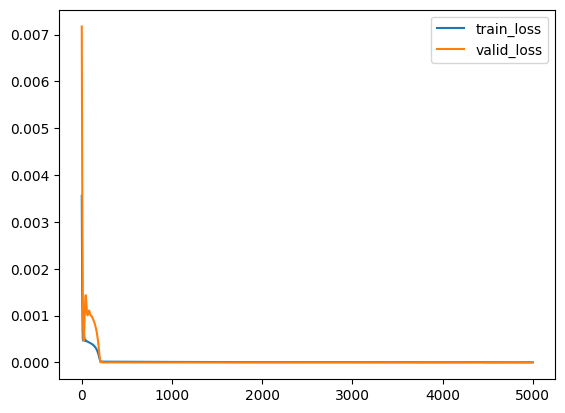

In [58]:
# 绘制 train_loss 曲线
plt.plot(train_losses, label='train_loss')
# 绘制 valid_loss 曲线
plt.plot(valid_losses, label='valid_loss')
# 展示带标签的图像
plt.legend()
plt.show()

下面绘制 `MAE` 与 `RMSE` 在 `epoch` 中的变化。

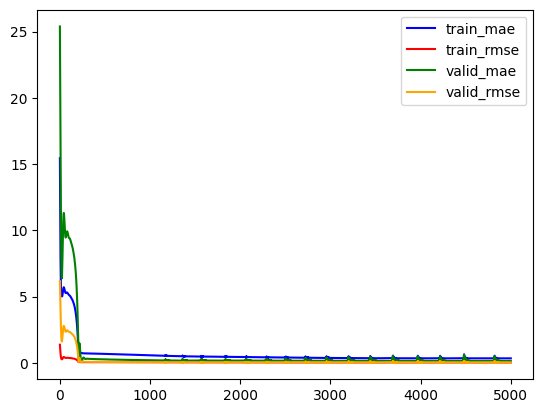

In [59]:
# 绘画结点
plt.plot(train_maes, c='blue', label='train_mae')
plt.plot(train_mapes, c='red', label='train_rmse')
plt.plot(valid_maes, c='green', label='valid_mae')
plt.plot(valid_mapes, c='orange', label='valid_rmse')
# 展示图像
plt.legend()
plt.show()

绘制在`训练集`的测试情况

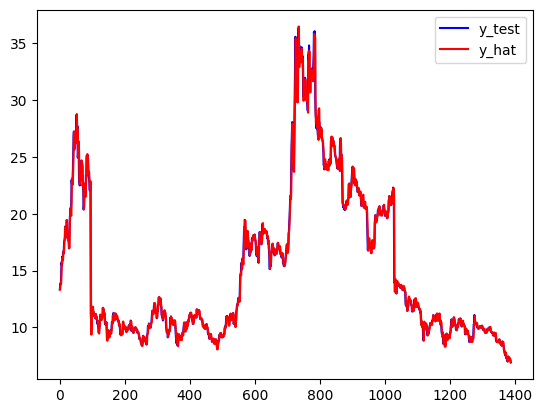

In [60]:
model.eval()
y_hat = model(x_train.to(DEVICE)).detach().to('cpu')
plt.plot(scaler.inverse_transform(y_train.reshape(-1,1)).reshape(-1), c='blue', label='y_test')
plt.plot(scaler.inverse_transform(y_hat.detach().reshape(-1,1)).reshape(-1), c='red', label='y_hat')
plt.legend()
plt.show()

绘制在`验证集`的测试情况

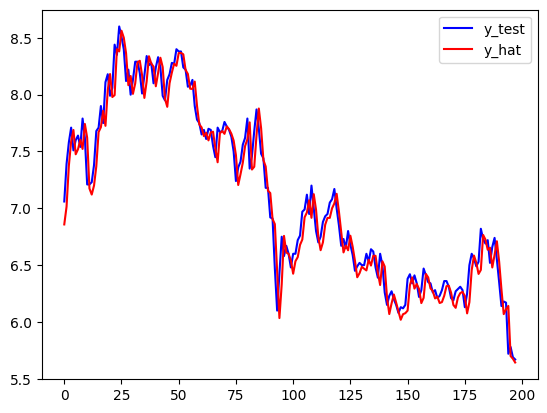

In [61]:
y_hat = model(x_val.to(DEVICE)).detach().to('cpu')
plt.plot(scaler.inverse_transform(y_val.reshape(-1,1)).reshape(-1), c='blue', label='y_test')
plt.plot(scaler.inverse_transform(y_hat.detach().reshape(-1,1)).reshape(-1), c='red', label='y_hat')
plt.legend()
plt.show()

绘制在`测试集`的测试情况

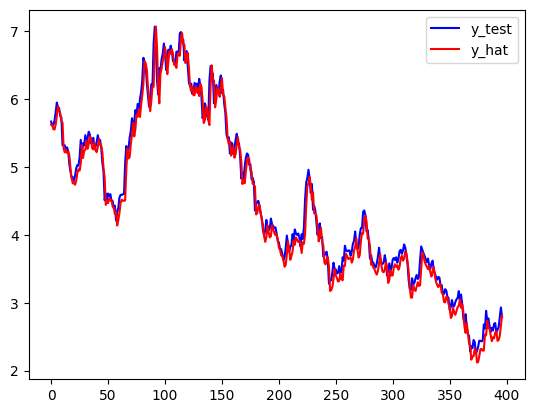

In [62]:
y_hat = model(x_test.to(DEVICE)).detach().to('cpu')
plt.plot(scaler.inverse_transform(y_test.reshape(-1,1)).reshape(-1), c='blue', label='y_test')
plt.plot(scaler.inverse_transform(y_hat.detach().reshape(-1,1)).reshape(-1), c='red', label='y_hat')
plt.legend()
plt.show()

可以看到，在`epoch = 5000`时模型已经趋于收敛，并在训练集、测试集、验证集上都表现出了良好的验证效果。  
以下给出不同epoch的训练情况

epoch = 1500  
![Alt text](LSTM1500.png)

epoch = 2000  
![Alt text](LSTM2000.png)

epoch = 4000  
![Alt text](LSTM4000.png)

epoch = 10000  
![Alt text](epoch10000.png)

**提交模型的训练结果图：**  
![Alt text](loss.png)  
![Alt text](mae.png)

### 2.3.6 保存和读取模型

下面介绍保存和读取模型。模型应当保存在`results`文件夹下。

In [63]:
model.to('cpu')
torch.save(model.state_dict(), 'report.pt',_use_new_zipfile_serialization=False)

读取模型

In [64]:
# 指定目录
model_path = 'report.pt'
# 选用使用的模型类
model = LSTMNet(num_inputs,num_outputs)
# 读入对应的参数
model.load_state_dict(torch.load(model_path))
model.eval()

LSTMNet(
  (rnn): LSTM(1, 14, batch_first=True)
  (dense): Linear(in_features=14, out_features=1, bias=True)
)

## 2.4 其他测试模型
在完成实验的过程中，我还尝试了如下几种模型来进行测试：

**单层线性网络：**

In [ ]:
class OneLinear(torch.nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(OneLinear, self).__init__()
        #线性层
        self.linear = torch.nn.Linear(num_inputs, num_outputs)
        # 前向传播函数
    def forward(self, x): # x shape: (batch, 14)
        y = self.linear(x)
        return y

当epoch增多时可以达到一定的预测效果，接下来进行了测试：   
<div align=center><img src="pics/linearl.png" width="700" height='500' align='middle' /> </div>  
<div align=center><img src="pics/linearmse.png" width="700" height='500' align='middle' /> </div>  
<div align=center><img src="pics/linearloss.png" width="500" height='400' align='middle' /> </div>   

**令人惊讶的是，在平台的测试模块，单层线性网络的测试结果甚至好于LSTM网络。**   
所以最后提交的是采取单层线性网络的结果。

**多层线性神经网络（MLP）：**

In [ ]:
class LinearNet(torch.nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(LinearNet, self).__init__()
        #线性层
        self.linear = torch.nn.Linear(num_inputs, 7)
        self.linear2 = torch.nn.Linear(7, 3)
        self.linear3 = torch.nn.Linear(3, num_outputs)
        # dropout 层，这里的参数指 dropout 的概率
        self.dropout = torch.nn.Dropout(0.3)
        self.dropout2 = torch.nn.Dropout(0.5)
        # ReLU 层
        self.gelu = torch.nn.GELU()
    # 前向传播函数
    def forward(self, x): # x shape: (batch, 14)
        x = self.linear(x)
        x = self.dropout(x)
        x = self.gelu(x)
        x = self.linear2(x)
        x = self.dropout2(x)
        x = self.gelu(x)
        y = self.linear3(x)
        return y

epoch = 1000，结果如下：  
![Alt text](Screenshot%20from%202022-12-05%2001-06-20.png)  
test mae, rmse: 0.439,0.110   
结果一般，没有沿用

**LSTM网络，两层线性输出**

In [ ]:
num_hiddens = 14 
num_inputs = 14
num_outputs = 1
# 建立一个稍微复杂的 LSTM 模型
class LSTMNet(torch.nn.Module):
    def __init__(self, num_hiddens, num_outputs):
        super(LSTMNet, self).__init__()
        self.hidden_size = num_hiddens
        self.rnn = torch.nn.LSTM(1,self.hidden_size,1,batch_first=True)
        # 线性层
        self.dense = torch.nn.Linear(self.hidden_size, 256)
        self.dense2 = torch.nn.Linear(256,num_outputs)
        # dropout 层，这里的参数指 dropout 的概率
        self.dropout = torch.nn.Dropout(0.3)
        self.dropout2 = torch.nn.Dropout(0.5)
        # ReLU 层
        self.relu = torch.nn.ReLU()
    
    # 前向传播函数，这是一个拼接的过程，使用大量变量是为了避免混淆，不做过多讲解
    def forward(self, x): 
        x = x.unsqueeze(-1)
        h, _ = self.rnn(x)
        h_d = self.dropout(h)
        y = self.dense(h_d)
        drop_y = self.dropout2(y)
        a = self.relu(drop_y)
        y2 = self.dense2(a)[:,-1,:]
        return y2

但是由于上述网络epoch训练过少，效果并不好  
![Alt text](Screenshot%20from%202022-12-05%2001-11-56.png)  
![Alt text](Screenshot%20from%202022-12-05%2001-13-40.png)

**Tensorflow的LSTM模型：**  
![Alt text](Screenshot%20from%202022-12-05%2001-19-30.png)

In [ ]:
def train():
    '''训练模型
    :return: model 一个训练好的模型
    '''
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(8, activation='relu', return_sequences=True, kernel_regularizer=keras.regularizers.l2(0.01)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(16, activation='relu', return_sequences=True, kernel_regularizer=keras.regularizers.l2(0.01)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.LSTM(32, activation='relu', return_sequences=True, kernel_regularizer=keras.regularizers.l2(0.01)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1)
    ])
    # --------------------------- 此处下方加入训练模型相关代码 -------------------------------
    model.compile(optimizer = keras.optimizers.Adam(0.001),  # adam优化器学习率0.001
              loss = tf.keras.losses.MeanAbsoluteError(),  # 标签和预测之间绝对差异的平均值
              metrics = tf.keras.losses.MeanSquaredLogarithmicError())  # 计算标签和预测之间的对数误差均方值。

    epochs = 1000  # 网络迭代次数
    # 网络训练
    history = model.fit(train_ds, epochs=epochs, validation_data=val_ds,batch_size=512)
    #（10）查看训练信息
    history_dict = history.history  # 获取训练的数据字典
    train_loss = history_dict['loss']  # 训练集损失
    val_loss = history_dict['val_loss']  # 验证集损失
    train_msle = history_dict['mean_squared_logarithmic_error']  # 训练集的百分比误差
    val_msle = history_dict['val_mean_squared_logarithmic_error']  # 验证集的百分比误差

    #（11）绘制训练损失和验证损失
    plt.figure()
    plt.plot(range(epochs), train_loss, label='train_loss')  # 训练集损失
    plt.plot(range(epochs), val_loss, label='val_loss')  # 验证集损失
    plt.legend()  # 显示标签
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.show()

    #（12）绘制训练百分比误差和验证百分比误差
    plt.figure()
    plt.plot(range(epochs), train_msle, label='train_msle')  # 训练集损失
    plt.plot(range(epochs), val_msle, label='val_msle')  # 验证集损失
    plt.legend()  # 显示标签
    plt.xlabel('epochs')
    plt.ylabel('msle')
    plt.show()

    # 如果使用的不是 pytorch 框架，还需要改动下面的代码
    # 模型保存的位置
    model_path = 'results/mymodel.pt'
    # 保存模型
    #torch.save(model.state_dict(), model_path)
    model.save('results/mymodel.h5')
    # --------------------------- 此处上方加入训练模型相关代码 -------------------------------
    return model
model = train()

训练结果：  
![Alt text](Screenshot%20from%202022-12-05%2001-17-42.png)  
但是由于tensorflow版本原因，在测试时出现了一些问题，只好放弃。

**多层LSTM模型：**

In [ ]:
class LSTMNet2(torch.nn.Module):
    def __init__(self, num_hiddens, num_outputs):
        super(LSTMNet, self).__init__()
        self.hidden_size = num_hiddens
        self.rnn = torch.nn.LSTM(1,16,1,batch_first=True)
        self.rnn = torch.nn.LSTM(1,8,1,batch_first=True)
        # 线性层
        self.dense = torch.nn.Linear(16, 8)
        self.dense2 = torch.nn.Linear(8,num_outputs)
        # dropout 层，这里的参数指 dropout 的概率
        self.dropout = torch.nn.Dropout(0.3)
        self.dropout2 = torch.nn.Dropout(0.5)
        # ReLU 层
        self.relu = torch.nn.ReLU()
    
    # 前向传播函数，这是一个拼接的过程，使用大量变量是为了避免混淆，不做过多讲解
    def forward(self, x): 
        x = x.unsqueeze(-1)
        h, _ = self.rnn(x)
        h_d = self.dropout(h)
        y = self.dense(h_d)
        drop_y = self.dropout2(y)
        a = self.relu(drop_y)
        y2 = self.dense2(a)[:,-1,:]
        return y

由于单层LSTM模型已经达到了较好的效果，故并没有尝试此类方法进行验证。

# 3 模型预测

注意事项：
1. 本实验并不严格限定使用的框架，可以使用 `Pytorch` , `Tensorflow` 或其他框架。只需训练好模型并保存，并在下文中写入合适的读取模型并实现预测即可。
2. 点击左侧栏`提交作业`后点击`生成文件`则只需勾选 `predict()` 函数的cell，即【**模型预测代码答题区域**】的 cell。
3. 请导入必要的包和第三方库 (包括此文件中曾经导入过的)。
4. 请加载你认为训练最佳的模型，即请按要求填写模型路径。
5. `predict()`函数的输入和输出请**不要改动**。
6. 注意，模型预测 `x.shape[0] < 20000` 的数据不能超过 $5$ 分钟，否则将被记为超时。
7. `predict()`函数 返回的类型必须是 `numpy` 数组类型。
8. 实验指标为平均绝对误差（ `MAPE` ）和平均绝对误差（ `MAE` ）。
9. 作业测试时记得填写你的模型路径及名称, 如果采用 [离线任务](https://momodel.cn/docs/#/zh-cn/%E5%9C%A8GPU%E6%88%96CPU%E8%B5%84%E6%BA%90%E4%B8%8A%E8%AE%AD%E7%BB%83%E6%9C%BA%E5%99%A8%E5%AD%A6%E4%B9%A0%E6%A8%A1%E5%9E%8B) 请将模型保存在 **results** 文件夹下。

In [65]:
# 1.导入相关第三方库或者包（根据自己需求，可以增加、删除等改动）
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import os
import torch
from sklearn.preprocessing import MinMaxScaler

# 2.导入 Notebook 使用的模型
class LSTMNet(torch.nn.Module):
    def __init__(self, num_hiddens, num_outputs):
        super(LSTMNet, self).__init__()
        self.hidden_size = num_hiddens
        self.rnn = torch.nn.LSTM(1,self.hidden_size,1,batch_first=True)
        # 线性层
        self.dense = torch.nn.Linear(self.hidden_size, 1)

        # 前向传播函数，这是一个拼接的过程，使用大量变量是为了避免混淆，不做过多讲解
    def forward(self, x): 
        x = x.unsqueeze(-1)
        h, _ = self.rnn(x)
        y = self.dense(h)[:,-1,:]
        return y


# 加载 Notebook 模型流程
scaler = MinMaxScaler().fit(np.array([0, 300]).reshape(-1, 1))
# 输入的数量是前 14 个交易日的收盘价
num_inputs = 14
# 输出是下一个交易日的收盘价
num_outputs = 1

# ------------------------- 请加载您最满意的模型网络结构 -----------------------------
# 读取模型

model = LSTMNet(num_inputs,num_outputs)
    
# ----------------------------- 请加载您最满意的模型 -------------------------------
# 加载模型(请加载你认为的最佳模型)
# 加载模型,加载请注意 model_path 是相对路径, 与当前文件同级。
# 如果你的模型是在 results 文件夹下的 temp.pth 模型，则 model_path = 'results/mymodel.pt'
# 模型保存的位置，如果模型路径不同，请修改！！！
model_path = 'report.pt'
model.load_state_dict(torch.load(model_path))
model.eval()

def predict(test_x):
    '''
    对于给定的 x 预测未来的 y 。
    :param test_x: 给定的数据集合 x ，对于其中的每一个元素需要预测对应的 y 。e.g.:np.array([[6.69,6.72,6.52,6.66,6.74,6.55,6.35,6.14,6.18,6.17,5.72,5.78,5.69,5.67]]
    :return: test_y 对于每一个 test_x 中的元素，给出一个对应的预测值。e.g.:np.array([[0.0063614]])
    '''
    # test 的数目
    n_test = test_x.shape[0]
    
    test_y = None
    # --------------------------- 此处下方加入读入模型和预测相关代码 -------------------------------
    # 此处为 Notebook 模型示范，你可以根据自己数据处理方式进行改动
    # scaler = MinMaxScaler().fit(np.array([0, 300]).reshape(-1, 1))
    test_x = scaler.transform(test_x.reshape(-1, 1)).reshape(-1, 14)
    test_x = torch.tensor(test_x, dtype=torch.float32)
    
    test_y = model(test_x)
    
    # 如果使用 MinMaxScaler 进行数据处理，预测后应使用下一句将预测值放缩到原范围内
    test_y = scaler.inverse_transform(test_y.detach().cpu())
    #test_y = test_y.detach().cpu().numpy()
    # --------------------------- 此处上方加入读入模型和预测相关代码 -------------------------------
    
    # 保证输出的是一个 numpy 数组
    assert(type(test_y) == np.ndarray)
    
    # 保证 test_y 的 shape 正确
    assert(test_y.shape == (n_test, 1))
    
    return test_y

创建数组进行测试：

In [66]:
# 测试用例
model_test_x = np.array([[6.69,6.72,6.52,6.66,6.74,6.55,6.35,6.14,6.18,6.17,5.72,5.78,5.69,5.67]])
print(predict(test_x = model_test_x))

[[5.62456101]]


在Mo平台上测试的几次较好结果：    
![Alt text](pics/Screenshot%20from%202022-12-06%2021-03-32.png)

# 4.实验总结  
在本次`A股预测`的实验中，我通过单层线性网络、多层感知机、LSTM长短期记忆网络等多种方法对原命题进行探究，得出了一个比较好的模型与解答。  
在探究过程中，对于Python、Pytorch等框架有了更一步的认识，理解了模型的搭建、训练与测试方法，提升了编程能力。  
同时，我也发现模型并不是越复杂，对于命题的解释能力就越强；有时候，简单的模型反而能起到更充分的表达效果。  
疑问：为什么在训练的过程中Loss有时会出现突然的波动？